✅ Gráfico salvo em plots/resource_usage_1800_seconds_400_threads_read_workload.png


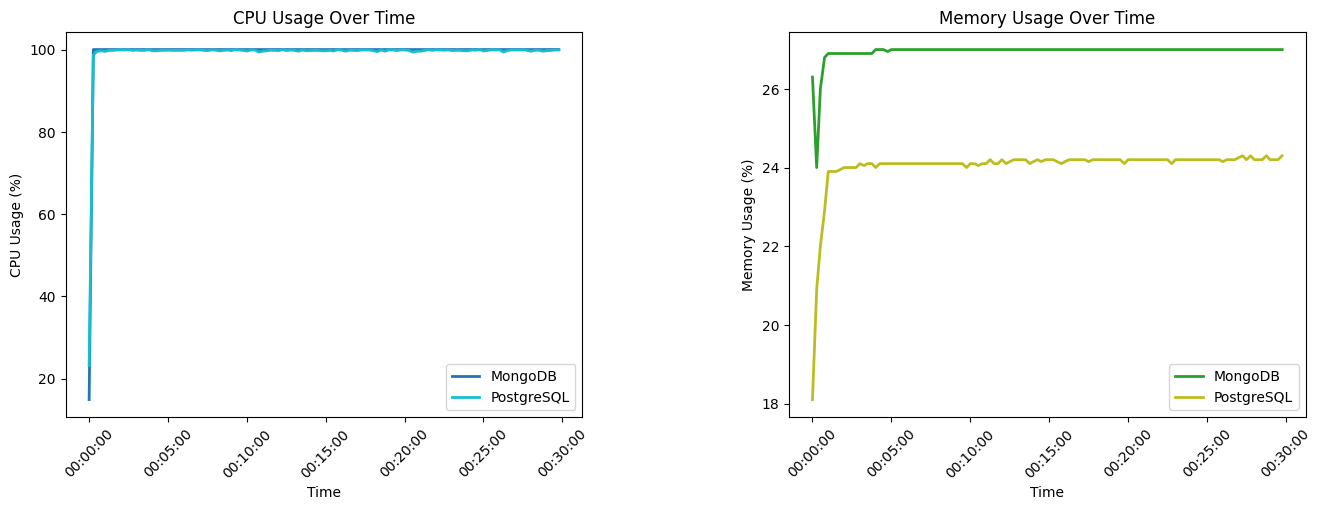

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import os

scenario = "1800_seconds_400_threads_read_workload"

mongo_file = f'resource-usage/mongo_{scenario}.csv'
pg_file = f'resource-usage/pg_{scenario}.csv'

# === Ler os dados ===
df_mongo = pd.read_csv(mongo_file)
df_pg = pd.read_csv(pg_file)

# === Converter 'Time' de timestamp para datetime ===
df_mongo['Time'] = pd.to_datetime(df_mongo['Time'], unit='s')
df_pg['Time'] = pd.to_datetime(df_pg['Time'], unit='s')

# === Normalizar timestamps para elapsed time (segundos desde início) ===
df_mongo['ElapsedTime'] = (df_mongo['Time'] - df_mongo['Time'].iloc[0]).dt.total_seconds()
df_pg['ElapsedTime'] = (df_pg['Time'] - df_pg['Time'].iloc[0]).dt.total_seconds()

# === Criar um eixo de tempo comum ===
common_time = pd.Series(sorted(set(df_mongo['ElapsedTime']).union(df_pg['ElapsedTime'])))

# Interpolar para alinhar os tempos
df_mongo_interp = df_mongo.set_index('ElapsedTime').reindex(common_time).interpolate(method='linear')
df_pg_interp = df_pg.set_index('ElapsedTime').reindex(common_time).interpolate(method='linear')

# Criar coluna de tempo formatada
time_index = pd.to_datetime(common_time, unit='s')

# Reduzir pontos (opcional)
N = 15  # ou 10 se quiser menos pontos
time_index = time_index[::N]
df_mongo_interp = df_mongo_interp.iloc[::N]
df_pg_interp = df_pg_interp.iloc[::N]

# === Plot (somente CPU e Memória) ===
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 1️⃣ CPU Usage
axs[0].plot(time_index, df_mongo_interp['CPU Usage'], label='MongoDB', color='tab:blue', linewidth=2)
axs[0].plot(time_index, df_pg_interp['CPU Usage'], label='PostgreSQL', color='tab:cyan', linewidth=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('CPU Usage (%)')
axs[0].set_title('CPU Usage Over Time')
axs[0].legend(loc='lower right')
axs[0].tick_params(axis='x', rotation=45)

# 2️⃣ Memory Usage
axs[1].plot(time_index, df_mongo_interp['Memory Usage'], label='MongoDB', color='tab:green', linewidth=2)
axs[1].plot(time_index, df_pg_interp['Memory Usage'], label='PostgreSQL', color='tab:olive', linewidth=2)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Memory Usage (%)')
axs[1].set_title('Memory Usage Over Time')
axs[1].legend(loc='lower right')
axs[1].tick_params(axis='x', rotation=45)

for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))

plt.subplots_adjust(hspace=0.4, wspace=0.4)

image_file = f'plots/resource_usage_{scenario}.png'
os.makedirs('plots', exist_ok=True)
plt.savefig(image_file, dpi=300, bbox_inches='tight')

print(f"✅ Gráfico salvo em {image_file}")

plt.show()